# 10차시: 포트폴리오와 최적화 (Portfolio Optimization)

## 학습 목표
- 포트폴리오의 개념과 분산투자의 중요성 이해
- 포트폴리오 수익률, 변동성, 샤프비율 계산
- 효율적 투자선(Efficient Frontier) 시각화 실습

## 학습 내용
1. 포트폴리오의 개념
2. 데이터 수집 (pykrx)
3. 로그 수익률 및 상관관계
4. 포트폴리오 지표 계산
5. Monte Carlo 시뮬레이션
6. 효율적 투자선 시각화


In [1]:
# 라이브러리 설치
!pip install pykrx -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.7/264.7 kB 12.9 MB/s eta 0:00:00


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 117528 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
Korean font ready: NanumGothic


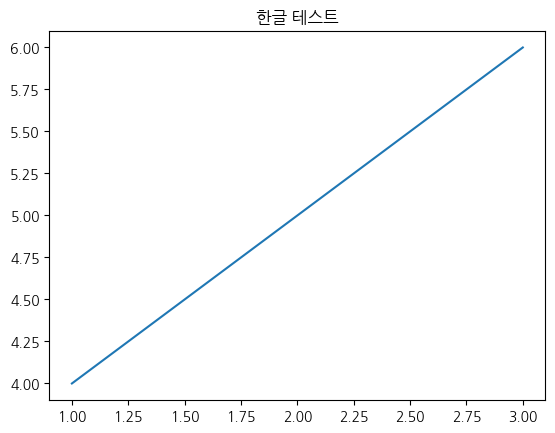

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def setup_korean_font_colab(verbose=True):
    """Colab 한글 폰트 설정"""
    import os
    import matplotlib as mpl
    import matplotlib.font_manager as fm
    font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
    if not os.path.exists(font_path):
        !apt-get update -qq
        !apt-get install -y fonts-nanum -qq
        pass
    try:
        fm.fontManager.addfont(font_path)
    except:
        pass
    font_name = fm.FontProperties(fname=font_path).get_name()
    mpl.rcParams["font.family"] = font_name
    mpl.rcParams["axes.unicode_minus"] = False
    if verbose:
        print(f"Korean font ready: {font_name}")
    return font_name

setup_korean_font_colab()

# 테스트
plt.plot([1, 2, 3], [4, 5, 6])
plt.title('한글 테스트')
plt.show()

---
## 1. 포트폴리오의 개념

### 포트폴리오란?
- 여러 자산에 분산 투자하여 구성한 자산의 집합
- "계란을 한 바구니에 담지 마라" - 분산투자의 원칙

### 분산투자의 효과
| 개념 | 설명 |
|------|------|
| **비체계적 위험** | 개별 종목의 고유 위험 (분산으로 감소 가능) |
| **체계적 위험** | 시장 전체의 위험 (분산으로 감소 불가) |

### 포트폴리오 주요 지표
| 지표 | 의미 |
|------|------|
| 기대 수익률 | 포트폴리오의 예상 수익 |
| 변동성 (위험) | 수익률의 표준편차 |
| 샤프 비율 | 위험 대비 수익 (높을수록 좋음) |

### 샤프 비율 공식
$$SR = \frac{R_p - R_f}{\sigma_p}$$
- $R_p$: 포트폴리오 수익률
- $R_f$: 무위험 수익률 (보통 0으로 가정)
- $\sigma_p$: 포트폴리오 변동성

---
## 2. 데이터 수집 (pykrx)

4개 종목으로 포트폴리오를 구성합니다.

In [3]:
# 데이터 수집 (pykrx)
from pykrx import stock

print("[포트폴리오 데이터 수집]")
print("=" * 60)

# 기간 설정 (최근 1년)
end_date = datetime.now()
start_date = end_date - timedelta(days=365)
start_str = start_date.strftime('%Y%m%d')
end_str = end_date.strftime('%Y%m%d')

# 포트폴리오 구성 종목 (4개)
stock_list = [
    ('005930', '삼성전자'),
    ('000660', 'SK하이닉스'),
    ('035420', 'NAVER'),
    ('051910', 'LG화학')
]

# 각 종목 종가 데이터 수집
portfolio = pd.DataFrame()

for code, name in stock_list:
    df = stock.get_market_ohlcv_by_date(start_str, end_str, code)
    portfolio[name] = df['종가']
    print(f"  - {name} ({code}): {len(df)}개 데이터")

print(f"\n포트폴리오 종목: {portfolio.columns.tolist()}")
print(f"기간: {portfolio.index[0].strftime('%Y-%m-%d')} ~ {portfolio.index[-1].strftime('%Y-%m-%d')}")
portfolio.tail()

[포트폴리오 데이터 수집]
  - 삼성전자 (005930): 242개 데이터
  - SK하이닉스 (000660): 242개 데이터
  - NAVER (035420): 242개 데이터
  - LG화학 (051910): 242개 데이터

포트폴리오 종목: ['삼성전자', 'SK하이닉스', 'NAVER', 'LG화학']
기간: 2025-01-02 ~ 2025-12-30


,삼성전자,SK하이닉스,NAVER,LG화학
날짜,,,,
2025-12-23,111500,584000,237000,345500
2025-12-24,111100,588000,236500,346000
2025-12-26,117000,599000,231500,336000
2025-12-29,119500,640000,242000,338500
2025-12-30,119900,651000,242500,333000



[포트폴리오 종목 주가 추이]


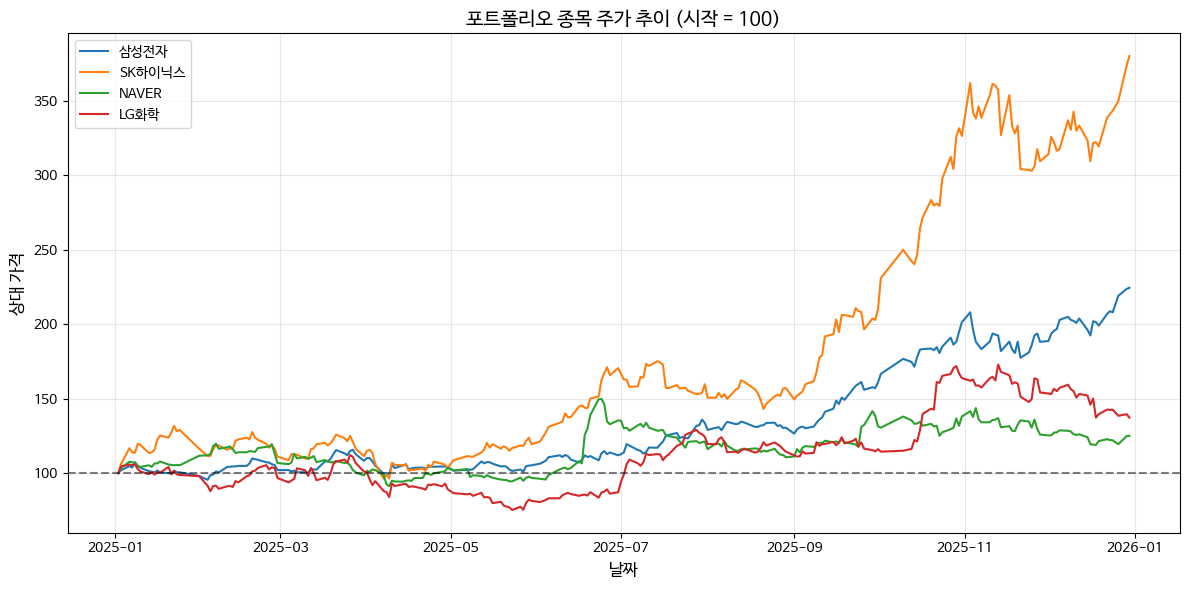

In [4]:
# 주가 추이 시각화
print("\n[포트폴리오 종목 주가 추이]")
print("=" * 60)

# 정규화 (시작가 = 100)
normalized = (portfolio / portfolio.iloc[0]) * 100

plt.figure(figsize=(12, 6))
for col in normalized.columns:
    plt.plot(normalized.index, normalized[col], linewidth=1.5, label=col)

plt.title('포트폴리오 종목 주가 추이 (시작 = 100)', fontsize=14, fontweight='bold')
plt.xlabel('날짜', fontsize=12)
plt.ylabel('상대 가격', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.axhline(y=100, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

---
## 3. 로그 수익률 및 상관관계

### 로그 수익률
- 일반 수익률보다 통계적 분석에 적합
- 공식: $r_t = \log(P_t / P_{t-1})$

### 상관관계
- 종목 간 상관관계가 낮을수록 분산투자 효과가 큼

In [5]:
# 로그 수익률 계산
print("[로그 수익률 계산]")
print("=" * 60)

log_ret = np.log(portfolio / portfolio.shift(1))
log_ret = log_ret.dropna()

print("\n[일별 로그 수익률 (최근 5일)]")
print(log_ret.tail())

print("\n[연간 평균 수익률]")
annual_ret = log_ret.mean() * 252
for name, ret in annual_ret.items():
    print(f"  - {name}: {ret*100:+.2f}%")

[로그 수익률 계산]

[일별 로그 수익률 (최근 5일)]
                삼성전자    SK하이닉스     NAVER      LG화학
날짜                                                
2025-12-23  0.009009  0.006873 -0.004211 -0.001446
2025-12-24 -0.003594  0.006826 -0.002112  0.001446
2025-12-26  0.051743  0.018535 -0.021368 -0.029328
2025-12-29  0.021142  0.066207  0.044358  0.007413
2025-12-30  0.003342  0.017041  0.002064 -0.016382

[연간 평균 수익률]
  - 삼성전자: +84.58%
  - SK하이닉스: +139.66%
  - NAVER: +23.44%
  - LG화학: +33.16%



[종목 간 상관관계]
         삼성전자  SK하이닉스  NAVER   LG화학
삼성전자    1.000   0.566  0.240  0.398
SK하이닉스  0.566   1.000  0.226  0.322
NAVER   0.240   0.226  1.000  0.139
LG화학    0.398   0.322  0.139  1.000


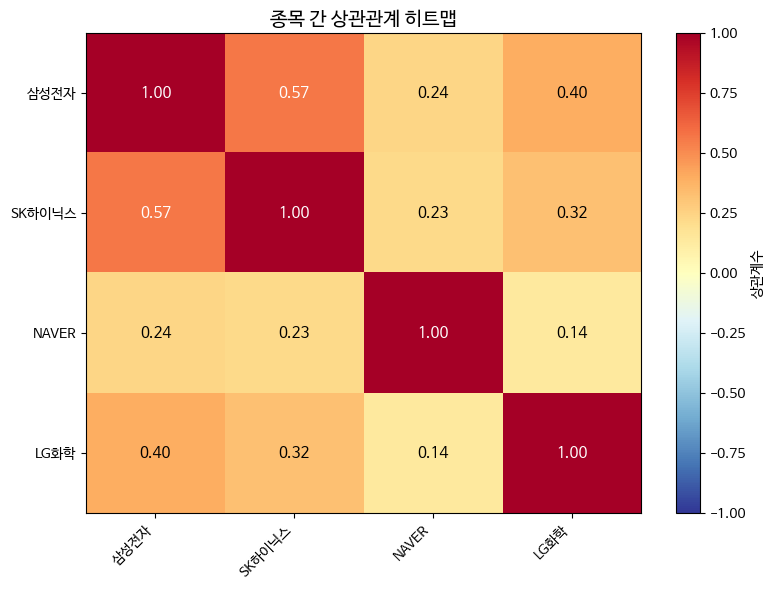


[해석] 상관관계가 낮을수록 분산투자 효과가 큼
       (1에 가까우면 같이 움직임, 0에 가까우면 독립적)


In [6]:
# 상관관계 분석
print("\n[종목 간 상관관계]")
print("=" * 60)

corr_matrix = log_ret.corr()
print(corr_matrix.round(3))

# 히트맵 시각화
plt.figure(figsize=(8, 6))
im = plt.imshow(corr_matrix, cmap='RdYlBu_r', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(im, label='상관계수')
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.title('종목 간 상관관계 히트맵', fontsize=14, fontweight='bold')

# 값 표시
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        color = 'white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black'
        plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                 ha='center', va='center', fontsize=11, color=color)
plt.tight_layout()
plt.show()

print("\n[해석] 상관관계가 낮을수록 분산투자 효과가 큼")
print("       (1에 가까우면 같이 움직임, 0에 가까우면 독립적)")

---
## 4. 포트폴리오 지표 계산

### 포트폴리오 수익률
$$R_p = \sum_{i=1}^{n} w_i \cdot R_i$$
- $w_i$: 자산 i의 비중
- $R_i$: 자산 i의 수익률

### 포트폴리오 변동성
$$\sigma_p = \sqrt{w^T \cdot \Sigma \cdot w}$$
- $\Sigma$: 공분산 행렬

### 샤프 비율
$$SR = \frac{R_p}{\sigma_p}$$ (무위험수익률 = 0 가정)

In [7]:
# 포트폴리오 지표 계산 함수
def calc_portfolio_metrics(weights, log_ret):
    """
    포트폴리오 수익률, 변동성, 샤프비율 계산

    Parameters:
    - weights: 자산별 비중 (합=1)
    - log_ret: 로그 수익률 DataFrame

    Returns:
    - (수익률, 변동성, 샤프비율)
    """
    weights = np.array(weights)

    # 연간 수익률: 각 자산의 평균 수익률 × 비중의 합 × 252일
    ret = np.sum(log_ret.mean() * weights) * 252

    # 연간 공분산 행렬
    cov_matrix = log_ret.cov() * 252

    # 연간 변동성: sqrt(w^T × Σ × w)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    # 샤프 비율 (무위험수익률 = 0 가정)
    sr = ret / vol

    return ret, vol, sr


print("[포트폴리오 지표 계산 함수 정의 완료]")
print("=" * 60)
print("calc_portfolio_metrics(weights, log_ret)")
print("  - weights: 자산별 비중 리스트 (합=1)")
print("  - 반환값: (연간 수익률, 연간 변동성, 샤프비율)")

[포트폴리오 지표 계산 함수 정의 완료]
calc_portfolio_metrics(weights, log_ret)
  - weights: 자산별 비중 리스트 (합=1)
  - 반환값: (연간 수익률, 연간 변동성, 샤프비율)


In [8]:
# 동일 비중 포트폴리오 테스트
print("\n[동일 비중 포트폴리오 분석]")
print("=" * 60)

n_assets = len(portfolio.columns)
equal_weights = [1/n_assets] * n_assets

ret, vol, sr = calc_portfolio_metrics(equal_weights, log_ret)

print(f"\n자산 비중 (동일 비중):")
for name, w in zip(portfolio.columns, equal_weights):
    print(f"  - {name}: {w:.2%}")

print(f"\n[포트폴리오 지표]")
print(f"  - 연간 기대 수익률: {ret:+.2%}")
print(f"  - 연간 변동성: {vol:.2%}")
print(f"  - 샤프 비율: {sr:.3f}")


[동일 비중 포트폴리오 분석]

자산 비중 (동일 비중):
  - 삼성전자: 25.00%
  - SK하이닉스: 25.00%
  - NAVER: 25.00%
  - LG화학: 25.00%

[포트폴리오 지표]
  - 연간 기대 수익률: +70.21%
  - 연간 변동성: 31.34%
  - 샤프 비율: 2.241


---
## 5. Monte Carlo 시뮬레이션

### 방법
1. 무작위로 자산 비중 생성 (합 = 1)
2. 해당 비중에서 수익률, 변동성, 샤프비율 계산
3. 수천~수만 번 반복하여 최적 포트폴리오 탐색

### 목표
- **최적 포트폴리오**: 샤프비율이 가장 높은 포트폴리오
- **최소 변동성 포트폴리오**: 위험이 가장 낮은 포트폴리오

In [9]:
# Monte Carlo 시뮬레이션
print("[Monte Carlo 시뮬레이션]")
print("=" * 60)

np.random.seed(42)

n_assets = len(log_ret.columns)
n_iterations = 10000

# 결과 저장 배열
all_weights = np.zeros((n_iterations, n_assets))
ret_arr = np.zeros(n_iterations)
vol_arr = np.zeros(n_iterations)
sr_arr = np.zeros(n_iterations)

print(f"자산 수: {n_assets}개")
print(f"시뮬레이션 횟수: {n_iterations:,}회")
print("\n시뮬레이션 진행 중...")

for i in range(n_iterations):
    # 무작위 비중 생성 (합 = 1)
    weights = np.random.random(n_assets)
    weights = weights / np.sum(weights)

    # 비중 저장
    all_weights[i, :] = weights

    # 지표 계산
    ret, vol, sr = calc_portfolio_metrics(weights, log_ret)
    ret_arr[i] = ret
    vol_arr[i] = vol
    sr_arr[i] = sr

print("시뮬레이션 완료!")
print(f"\n결과 범위:")
print(f"  - 수익률: {ret_arr.min():.2%} ~ {ret_arr.max():.2%}")
print(f"  - 변동성: {vol_arr.min():.2%} ~ {vol_arr.max():.2%}")
print(f"  - 샤프비율: {sr_arr.min():.3f} ~ {sr_arr.max():.3f}")

[Monte Carlo 시뮬레이션]
자산 수: 4개
시뮬레이션 횟수: 10,000회

시뮬레이션 진행 중...
시뮬레이션 완료!

결과 범위:
  - 수익률: 24.61% ~ 135.66%
  - 변동성: 28.51% ~ 52.62%
  - 샤프비율: 0.618 ~ 2.832


In [10]:
# 최적 포트폴리오 찾기
print("\n[최적 포트폴리오 (최대 샤프비율)]")
print("=" * 60)

max_sr_idx = sr_arr.argmax()
min_vol_idx = vol_arr.argmin()

print(f"\n[1] 최대 샤프비율 포트폴리오")
print(f"    샤프비율: {sr_arr[max_sr_idx]:.3f}")
print(f"    기대 수익률: {ret_arr[max_sr_idx]:+.2%}")
print(f"    변동성: {vol_arr[max_sr_idx]:.2%}")
print(f"    자산 비중:")
for name, weight in zip(log_ret.columns, all_weights[max_sr_idx]):
    print(f"      - {name}: {weight:.2%}")

print(f"\n[2] 최소 변동성 포트폴리오")
print(f"    샤프비율: {sr_arr[min_vol_idx]:.3f}")
print(f"    기대 수익률: {ret_arr[min_vol_idx]:+.2%}")
print(f"    변동성: {vol_arr[min_vol_idx]:.2%}")
print(f"    자산 비중:")
for name, weight in zip(log_ret.columns, all_weights[min_vol_idx]):
    print(f"      - {name}: {weight:.2%}")


[최적 포트폴리오 (최대 샤프비율)]

[1] 최대 샤프비율 포트폴리오
    샤프비율: 2.832
    기대 수익률: +103.64%
    변동성: 36.59%
    자산 비중:
      - 삼성전자: 63.00%
      - SK하이닉스: 35.80%
      - NAVER: 0.46%
      - LG화학: 0.74%

[2] 최소 변동성 포트폴리오
    샤프비율: 1.973
    기대 수익률: +56.23%
    변동성: 28.51%
    자산 비중:
      - 삼성전자: 51.11%
      - SK하이닉스: 0.03%
      - NAVER: 33.33%
      - LG화학: 15.53%


---
## 6. 효율적 투자선 (Efficient Frontier) 시각화

### 효율적 투자선이란?
- 동일한 위험 수준에서 **최대 수익**을 제공하는 포트폴리오의 집합
- 또는 동일한 수익 수준에서 **최소 위험**을 제공하는 포트폴리오의 집합
- 그래프의 **왼쪽 위 경계선**이 효율적 투자선

### 해석
- 효율적 투자선 위의 포트폴리오: 최적의 선택
- 효율적 투자선 아래의 포트폴리오: 비효율적 (같은 위험에서 더 낮은 수익)

[효율적 투자선 시각화]


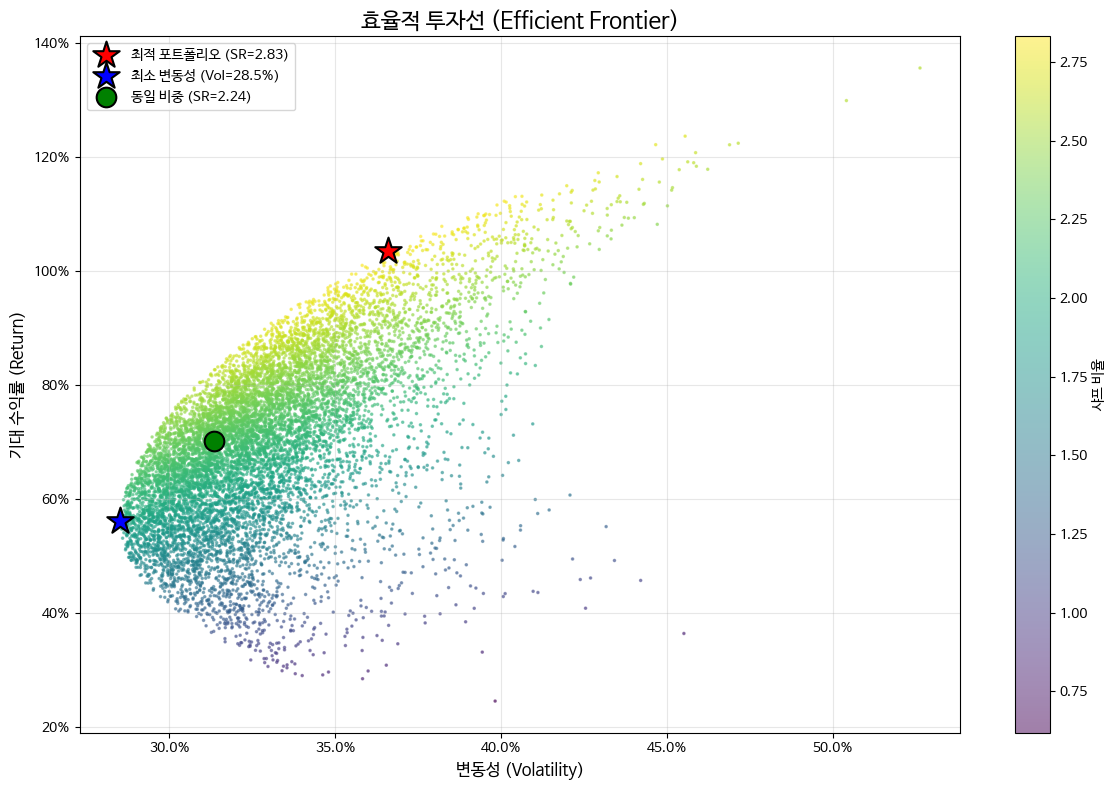

[차트 해석]
  - 노란색 영역: 샤프비율이 높은 효율적인 포트폴리오
  - 보라색 영역: 샤프비율이 낮은 비효율적인 포트폴리오
  - 빨간 별: 최대 샤프비율 포트폴리오 (최적)
  - 파란 별: 최소 변동성 포트폴리오
  - 녹색 원: 동일 비중 포트폴리오
  - 왼쪽 위 경계선이 '효율적 투자선'


In [11]:
# 효율적 투자선 시각화
print("[효율적 투자선 시각화]")
print("=" * 60)

plt.figure(figsize=(12, 8))

# 모든 포트폴리오 산점도 (샤프비율로 색상 구분)
scatter = plt.scatter(vol_arr, ret_arr, c=sr_arr, cmap='viridis',
                      marker='.', alpha=0.5, s=10)
plt.colorbar(scatter, label='샤프 비율')

# 최적 포트폴리오 (최대 샤프비율) - 빨간 별
plt.scatter(vol_arr[max_sr_idx], ret_arr[max_sr_idx],
            c='red', marker='*', s=400, edgecolors='black', linewidths=1.5,
            label=f'최적 포트폴리오 (SR={sr_arr[max_sr_idx]:.2f})', zorder=5)

# 최소 변동성 포트폴리오 - 파란 별
plt.scatter(vol_arr[min_vol_idx], ret_arr[min_vol_idx],
            c='blue', marker='*', s=400, edgecolors='black', linewidths=1.5,
            label=f'최소 변동성 (Vol={vol_arr[min_vol_idx]:.1%})', zorder=5)

# 동일 비중 포트폴리오 - 녹색 원
equal_ret, equal_vol, equal_sr = calc_portfolio_metrics(equal_weights, log_ret)
plt.scatter(equal_vol, equal_ret,
            c='green', marker='o', s=200, edgecolors='black', linewidths=1.5,
            label=f'동일 비중 (SR={equal_sr:.2f})', zorder=5)

plt.title('효율적 투자선 (Efficient Frontier)', fontsize=16, fontweight='bold')
plt.xlabel('변동성 (Volatility)', fontsize=12)
plt.ylabel('기대 수익률 (Return)', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)

# x축, y축 퍼센트 표시
import matplotlib.ticker as mtick
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.tight_layout()
plt.show()

print("[차트 해석]")
print("  - 노란색 영역: 샤프비율이 높은 효율적인 포트폴리오")
print("  - 보라색 영역: 샤프비율이 낮은 비효율적인 포트폴리오")
print("  - 빨간 별: 최대 샤프비율 포트폴리오 (최적)")
print("  - 파란 별: 최소 변동성 포트폴리오")
print("  - 녹색 원: 동일 비중 포트폴리오")
print("  - 왼쪽 위 경계선이 '효율적 투자선'")


[최적 포트폴리오 자산 비중]


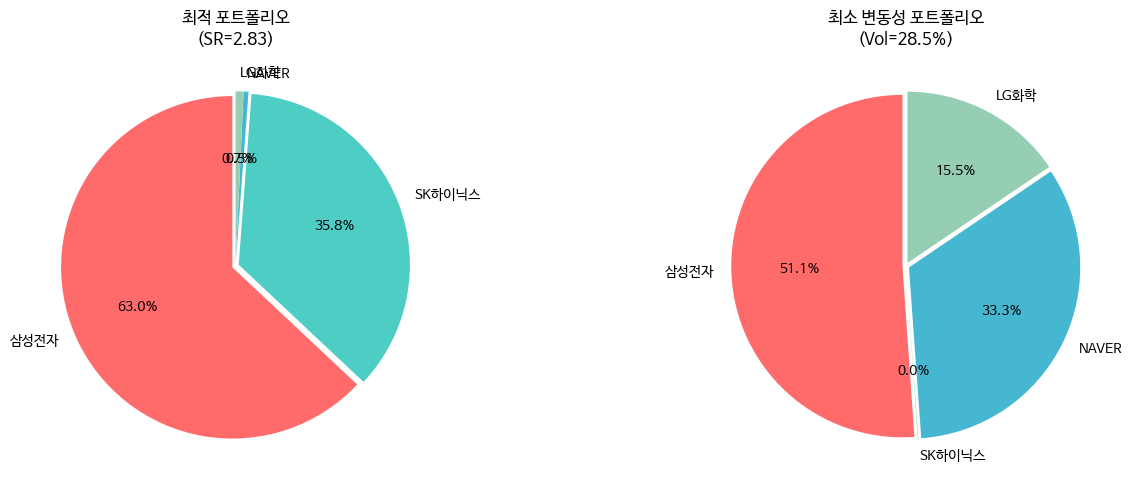


[포트폴리오 비교]
      구분   기대 수익률    변동성 샤프 비율
최적 포트폴리오 +103.64% 36.59% 2.832
  최소 변동성  +56.23% 28.51% 1.973
   동일 비중  +70.21% 31.34% 2.241


In [12]:
# 최적 포트폴리오 비중 시각화
print("\n[최적 포트폴리오 자산 비중]")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (1) 최대 샤프비율 포트폴리오 비중
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
axes[0].pie(all_weights[max_sr_idx], labels=log_ret.columns, autopct='%1.1f%%',
            colors=colors, startangle=90, explode=[0.02]*n_assets)
axes[0].set_title(f'최적 포트폴리오\n(SR={sr_arr[max_sr_idx]:.2f})', fontsize=12, fontweight='bold')

# (2) 최소 변동성 포트폴리오 비중
axes[1].pie(all_weights[min_vol_idx], labels=log_ret.columns, autopct='%1.1f%%',
            colors=colors, startangle=90, explode=[0.02]*n_assets)
axes[1].set_title(f'최소 변동성 포트폴리오\n(Vol={vol_arr[min_vol_idx]:.1%})', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# 비교표
print("\n[포트폴리오 비교]")
comparison = pd.DataFrame({
    '구분': ['최적 포트폴리오', '최소 변동성', '동일 비중'],
    '기대 수익률': [f'{ret_arr[max_sr_idx]:+.2%}', f'{ret_arr[min_vol_idx]:+.2%}', f'{equal_ret:+.2%}'],
    '변동성': [f'{vol_arr[max_sr_idx]:.2%}', f'{vol_arr[min_vol_idx]:.2%}', f'{equal_vol:.2%}'],
    '샤프 비율': [f'{sr_arr[max_sr_idx]:.3f}', f'{sr_arr[min_vol_idx]:.3f}', f'{equal_sr:.3f}']
})
print(comparison.to_string(index=False))

---
## 학습 정리

### 1. 포트폴리오 핵심 개념
- **분산투자**: 여러 자산에 투자하여 위험 분산
- **상관관계**: 낮을수록 분산투자 효과 큼

### 2. 주요 지표
| 지표 | 공식 | 의미 |
|------|------|------|
| 수익률 | $\sum w_i R_i$ | 기대 수익 |
| 변동성 | $\sqrt{w^T \Sigma w}$ | 위험 |
| 샤프비율 | 수익률 / 변동성 | 효율성 (높을수록 좋음) |

### 3. 효율적 투자선 (Efficient Frontier)
- 동일 위험에서 최대 수익을 주는 포트폴리오의 집합
- **최적 포트폴리오**: 샤프비율이 가장 높은 지점
- **최소 변동성 포트폴리오**: 위험이 가장 낮은 지점

### 4. Monte Carlo 시뮬레이션
- 무작위 비중 조합으로 최적 포트폴리오 탐색
- 시각화를 통해 효율적 투자선 확인

---

### Module 1 완료
다음 모듈에서는 경제/금융 지표 수집 자동화를 학습합니다.